# **Poker Cards Recognition Network**

# Data Loading

In [10]:
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random
import math

# Mount Google Drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/DeepLearning_2023/Final/poker-database.zip'
data_path = '/content/poker/'
results_path = '/content/drive/MyDrive/DeepLearning_2023/Final/Results/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# unzip database (no need to run if already in disk)
import zipfile
import os

if not os.path.exists(data_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as tf
from PIL import Image
import os

# Define labels_to_number and number_to_labels dictionaries
labels_to_number = {}
number_to_labels = {}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_path = []
        self.labels = []

        # Get the classes of the dataset
        classes = os.listdir(root_dir)
        classes.sort()

        for label_idx, class_name in enumerate(classes):

            # Create the dictionaries
            labels_to_number[class_name] = label_idx
            number_to_labels[label_idx] = class_name

            # Get the image paths of the current class
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)

            for image_file in image_files:
                # Open the image
                image_path = os.path.join(class_dir, image_file)

                if(not os.path.isdir(image_path)):
                    self.images_path.append(image_path)

                    self.labels.append(labels_to_number[class_name])

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        image = Image.open(image_path)

        # Apply the preprocessing
        image = self.transform(image)

        label = self.labels[idx]
        return image, label


# Compose the transformations
# NOTE: normalization is specified in EfficientNet documentation
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor(),
    tf.Normalize(mean=mean, std=std)
])

batch_size = 50

# Define the train loader
train_dataset = Dataset(data_path + "/train", tr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the validation loader
val_dataset = Dataset(data_path + "/valid", tr)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Load the test dataset
test_dataset = Dataset(data_path + '/test', tr)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Number of Classes
class_count = len(labels_to_number)
print(f"classes: {class_count}")
print(f"images: {len(train_dataset)}")

classes: 53
images: 7624


In [17]:
# function to "unnormalize" and plot a dataset image
def showNormalizedImage(image):
  plt.imshow(image * torch.FloatTensor(std) + torch.FloatTensor(mean))

Label: eight of clubs


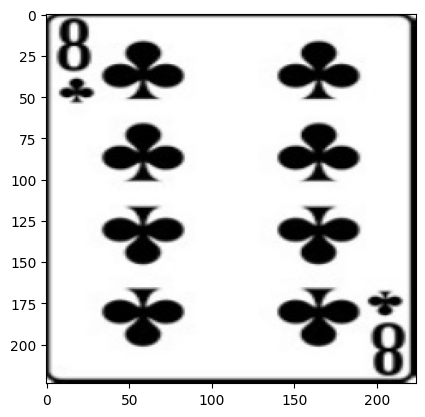

In [5]:
# print an example image
data_iter = iter(train_loader)
images, labels = next(data_iter)

example_image, example_label = images[0].permute(1, 2, 0), labels[0]

print('Label: ' + str(number_to_labels[example_label.item()]))
showNormalizedImage(example_image)

In [6]:
import gc

# Train function
def train(CNN, train_loader, val_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train()  # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    val_losses_list = []
    criterion = nn.CrossEntropyLoss()

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Training
        loss_avg = 0
        nBatches = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches += 1

            if (i + 1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

        print('Epoch [{}/{}], Training Loss: {:.4f}'
              .format(epoch + 1, num_epochs, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)

        # Validation
        CNN.eval()  # Set the model in evaluation mode
        val_loss_avg = 0
        val_nBatches = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                outputs = CNN(images)
                val_loss = criterion(outputs, labels)
                val_loss_avg += val_loss.cpu().item()
                val_nBatches += 1

        val_loss_avg /= val_nBatches
        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss_avg))
        val_losses_list.append(val_loss_avg)
        print(f'Validation Accuracy: {test(model, val_loader)}')

        CNN.train()  # Set the model back to train mode

        # Check if the results directory exists, or create it
        if not os.path.exists(results_path):
          os.makedirs(results_path)

        torch.save(CNN.state_dict(), results_path + '/' + model_name)

    return losses_list, val_losses_list


# Test funcion
def test(CNN, test_loader):
  CNN.eval()
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # return accuracy
        return 100 * correct / total

# Auxiliary Functions

In [ ]:
def plot_loss(loss_hist, val_loss_hist, model_name):

  # visualize the results
  plt.plot(loss_hist, '-.r', linewidth=1.0, label='train_loss')
  plt.plot(val_loss_hist,'-b', linewidth=1.0, label='val_loss')
  plt.xlabel('train step', fontsize=14)
  plt.ylabel('loss', fontsize=14)
  plt.title(model_name)
  plt.legend()
  plt.savefig(results_path + f"Loss_{model_name}.png")
  plt.show()

In [ ]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [ ]:
def printAccuracies(model, name="unknown model"):
  print(f'{name} Accuracies:')
  print(f'Training Accuracy: {test(model, train_loader)}')
  print(f'Validation Accuracy: {test(model, val_loader)}')

In [ ]:
import random

def initEnvironment():
  #Initialize random seed
  seed = 42
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  # free cuda memory
  gc.collect()
  torch.cuda.empty_cache()

# Model 1: MobileNetv2 (from Practice 3)

We decided to try with this network which had a pretty good performance on the SVNH dataset in the previous practice.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
  def __init__(self, in_channels, out_channels, expansion=1, stride=1):
    super(Bottleneck, self).__init__()

    bottleneck_channels = in_channels * expansion

    #A bottleneck is the sequence of a 1x1xexpanded_channels convolution, a 3x3xexpanded_channels conv and a 1x1xout_channels
    self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1)
    self.batchnorm1 = nn.BatchNorm2d(bottleneck_channels)
    self.relu = nn.ReLU()

    self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, groups=bottleneck_channels)
    self.batchnorm2 = nn.BatchNorm2d(bottleneck_channels)

    self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1)
    self.batchnorm3 = nn.BatchNorm2d(out_channels)

  def forward(self, x):

    out = self.conv1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.batchnorm3(out)
    out = self.relu(out)

    return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenetv2 Style Architecture
class Mobilenetv2(nn.Module):
    def __init__(self, num_classes=10):

        super(Mobilenetv2, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.relu = nn.ReLU()

        self.bottleneck1 = Bottleneck(32, 16, expansion=4)
        self.bottleneck2 = Bottleneck(16, 16, expansion=6)
        self.bottleneck3 = Bottleneck(16, 24, expansion=6)
        self.bottleneck4 = Bottleneck(24, 24, expansion=6)
        self.bottleneck5 = Bottleneck(24, 32, expansion=6)
        self.bottleneck6 = Bottleneck(32, 32, expansion=6)
        self.bottleneck7 = Bottleneck(32, 64, expansion=6)


        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(128)

        #Global averaging Pooling of Mobilenet.
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)

        self.linear = nn.Linear(128,num_classes)


    def forward(self, x):

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.bottleneck1(out)
        out = self.bottleneck2(out)
        out = self.bottleneck3(out)
        out = self.bottleneck4(out)
        out = self.bottleneck5(out)
        out = self.bottleneck6(out)
        out = self.bottleneck7(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)

        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        return out


In [ ]:
initEnvironment()

# create model
model = Mobilenetv2(num_classes=class_count)
name = "Mobilenetv2"

#Initialize optimizer
learning_rate = .001
weight_decay = 1e-3
num_epochs = 6

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,
                             weight_decay = weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer,
                                     num_epochs=num_epochs, model_name=f'{name}.ckpt',
                                     device=device)

cuda:0
Epoch [1/6], Step [10/153], Loss: 3.9618
Epoch [1/6], Step [20/153], Loss: 3.9212
Epoch [1/6], Step [30/153], Loss: 3.8816
Epoch [1/6], Step [40/153], Loss: 3.8523
Epoch [1/6], Step [50/153], Loss: 3.8220
Epoch [1/6], Step [60/153], Loss: 3.7927
Epoch [1/6], Step [70/153], Loss: 3.7744
Epoch [1/6], Step [80/153], Loss: 3.7455
Epoch [1/6], Step [90/153], Loss: 3.7235
Epoch [1/6], Step [100/153], Loss: 3.6994
Epoch [1/6], Step [110/153], Loss: 3.6764
Epoch [1/6], Step [120/153], Loss: 3.6547
Epoch [1/6], Step [130/153], Loss: 3.6311
Epoch [1/6], Step [140/153], Loss: 3.6076
Epoch [1/6], Step [150/153], Loss: 3.5850
Epoch [1/6], Training Loss: 3.5790
Epoch [1/6], Validation Loss: 3.1355
Validation Accuracy: 8.30188679245283
Epoch [2/6], Step [10/153], Loss: 3.2392
Epoch [2/6], Step [20/153], Loss: 3.2229
Epoch [2/6], Step [30/153], Loss: 3.2033
Epoch [2/6], Step [40/153], Loss: 3.1803
Epoch [2/6], Step [50/153], Loss: 3.1631
Epoch [2/6], Step [60/153], Loss: 3.1599
Epoch [2/6], Ste

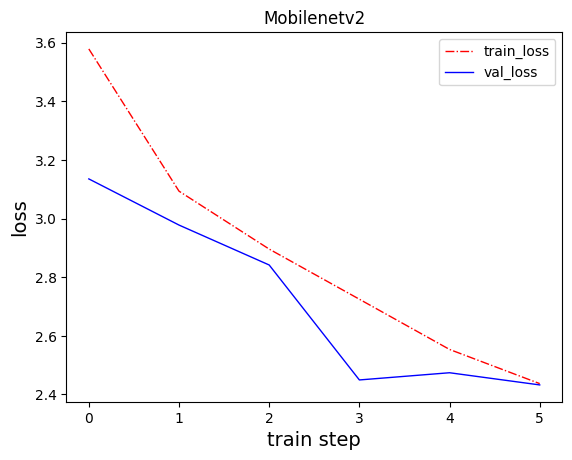

Mobilenetv2 Accuracies:
Training Accuracy: 23.176810073452256
Validation Accuracy: 22.264150943396228


In [ ]:
# Plot loss and print accuracy
plot_loss(losses_list, val_losses_list, name)
printAccuracies(model, name)

# Model 2: EfficientNet b3 (first version)

After obtaining bad results with Model 1, we chose to use transfer learning with an already trained EfficientNet b3 variant for images, and changing only the classifier layer.

In [ ]:
# we increase batch size for faster results
batch_size = 256

# Define the train loader
train_dataset = Dataset(data_path + "/train", tr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from torchvision.models import efficientnet_b3

# create model
model = efficientnet_b3(weights='DEFAULT')
name = "CustomEfficientNet-v1"

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features

# define new classifier layer which we will train
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(num_features, class_count),
    nn.LogSoftmax(dim=1)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 35.4MB/s]


In [ ]:
initEnvironment()

#Initialize optimizer
learning_rate = .001
weight_decay = 1e-3
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,
                             weight_decay = weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer,
                                     num_epochs=num_epochs, model_name=f'{name}.ckpt',
                                     device=device)

cuda:0
Epoch [1/10], Step [10/30], Loss: 3.8579
Epoch [1/10], Step [20/30], Loss: 3.7182
Epoch [1/10], Step [30/30], Loss: 3.5955
Epoch [1/10], Training Loss: 3.5955
Epoch [1/10], Validation Loss: 3.1418
Validation Accuracy: 27.547169811320753
Epoch [2/10], Step [10/30], Loss: 3.1127
Epoch [2/10], Step [20/30], Loss: 3.0200
Epoch [2/10], Step [30/30], Loss: 2.9489
Epoch [2/10], Training Loss: 2.9489
Epoch [2/10], Validation Loss: 2.7414
Validation Accuracy: 35.471698113207545
Epoch [3/10], Step [10/30], Loss: 2.6564
Epoch [3/10], Step [20/30], Loss: 2.6164
Epoch [3/10], Step [30/30], Loss: 2.5762
Epoch [3/10], Training Loss: 2.5762
Epoch [3/10], Validation Loss: 2.4748
Validation Accuracy: 38.867924528301884
Epoch [4/10], Step [10/30], Loss: 2.3819
Epoch [4/10], Step [20/30], Loss: 2.3589
Epoch [4/10], Step [30/30], Loss: 2.3414
Epoch [4/10], Training Loss: 2.3414
Epoch [4/10], Validation Loss: 2.3549
Validation Accuracy: 40.0
Epoch [5/10], Step [10/30], Loss: 2.2253
Epoch [5/10], Step

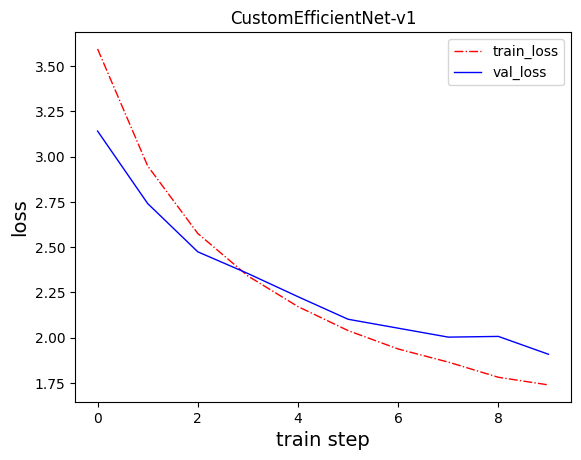

CustomEfficientNet-v1 Accuracies:
Training Accuracy: 70.02885624344177
Validation Accuracy: 42.264150943396224


In [ ]:
# Plot loss and print accuracy
plot_loss(losses_list, val_losses_list, name)
printAccuracies(model, name)

# Model 3: EfficientNet b3 (second version)

Model 2 also gave suboptimal results. Investigating, we found a configuration of a deeper classifier layer (using two fully connected layers and a dropout in between) that trained the whole EfficientNet model. Because of memory constraints, we only trained half of the model.

In [8]:
# code adapted from: https://www.kaggle.com/code/abdallahwagih/effecientnetb3-cards-classification-98-85

from torchvision.models import efficientnet_b3

def buildCustomEfficientNet():
  model = efficientnet_b3(weights='DEFAULT')

  # Freeze pre-trained layers
  for param in model.parameters():
      param.requires_grad = False

  num_features = model.classifier[1].in_features

  # change classifier layer
  model.classifier = nn.Sequential(
      nn.BatchNorm1d(num_features),
      nn.Linear(num_features, 256),
      nn.ReLU(),
      nn.Dropout(p=0.45),
      nn.Linear(256, class_count),
      nn.LogSoftmax(dim=1)
  )

  # we will build a list of trainable parameters
  parameters = list(model.classifier.parameters())
  layers_n = len(model.features)
  train_start = math.ceil(layers_n / 2)   # we will train the last half of the model

  # there are 9 sequentials in features, we will train half of them
  for i in range(train_start, layers_n):
    parameters += list(model.features[i].parameters())
    for param in model.features[i].parameters():
        param.requires_grad = True

  return model, parameters


In [ ]:
initEnvironment()

# create model
model, parameters = buildCustomEfficientNet()
name = "CustomEfficientNet-v2"

#Initialize optimizer
learning_rate = .001
weight_decay = 1e-3
num_epochs=10

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,
                             weight_decay = weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer,
                                     num_epochs=num_epochs, model_name=f'{name}.ckpt',
                                     device=device)

cuda:0
Epoch [1/10], Step [10/30], Loss: 3.6152
Epoch [1/10], Step [20/30], Loss: 3.0052
Epoch [1/10], Step [30/30], Loss: 2.4801
Epoch [1/10], Training Loss: 2.4801
Epoch [1/10], Validation Loss: 0.7379
Validation Accuracy: 77.73584905660377
Epoch [2/10], Step [10/30], Loss: 0.8105
Epoch [2/10], Step [20/30], Loss: 0.6943
Epoch [2/10], Step [30/30], Loss: 0.6207
Epoch [2/10], Training Loss: 0.6207
Epoch [2/10], Validation Loss: 0.3684
Validation Accuracy: 87.16981132075472
Epoch [3/10], Step [10/30], Loss: 0.2853
Epoch [3/10], Step [20/30], Loss: 0.2771
Epoch [3/10], Step [30/30], Loss: 0.2664
Epoch [3/10], Training Loss: 0.2664
Epoch [3/10], Validation Loss: 0.3540
Validation Accuracy: 87.9245283018868
Epoch [4/10], Step [10/30], Loss: 0.1474
Epoch [4/10], Step [20/30], Loss: 0.1529
Epoch [4/10], Step [30/30], Loss: 0.1624
Epoch [4/10], Training Loss: 0.1624
Epoch [4/10], Validation Loss: 0.4341
Validation Accuracy: 90.18867924528301
Epoch [5/10], Step [10/30], Loss: 0.1087
Epoch [5/

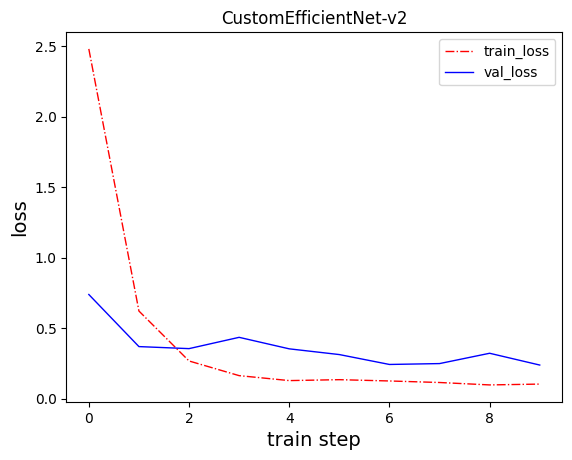

CustomEfficientNet-v2 Accuracies:
Training Accuracy: 98.80640083945435
Validation Accuracy: 94.71698113207547


In [ ]:
# Plot loss and print accuracy
plot_loss(losses_list, val_losses_list, name)
printAccuracies(model, name)

# Data Augmentation

To futher improvement the results of Model 3, we decided to increase the training dataset with data augmentation. We decided to use the RandomPerspective tranform as we expect real images we take of poker cards to not be perfectly aligned inside the frame.

In [ ]:
# We apply transformations to the images to create new files
import torchvision.transforms as tf

num_iterations = 2

transform = tf.RandomPerspective(distortion_scale=0.6, p=1.0)

root_dir = data_path + "train"

# Get the classes of the dataset
classes = os.listdir(root_dir)
classes.sort()

for class_name in classes:
    # Get the image paths of the current class
    class_dir = os.path.join(root_dir, class_name)
    image_files = os.listdir(class_dir)

    for idx, image_file in enumerate(image_files):
        # Check that it is not a dir
        if(not os.path.isdir(image_file)):
            # Open the image
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)

            for i in range(num_iterations):
                # Apply the transformations
                transformed_image = transform(image)
                transformed_image.save(f"{class_dir}/image_{idx}_augmented_{i}.jpg")

In [ ]:
# reload the training database
train_dataset = Dataset(data_path + "/train", tr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
initEnvironment()

# create model
model, parameters = buildCustomEfficientNet()
name = "CustomEfficientNet-v3"

#Initialize optimizer
learning_rate = .001
weight_decay = 1e-3
num_epochs=10

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,
                             weight_decay = weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer,
                                     num_epochs=num_epochs, model_name=f'{name}.ckpt',
                                     device=device)

cuda:0
Epoch [1/10], Step [10/90], Loss: 3.6444
Epoch [1/10], Step [20/90], Loss: 3.0838
Epoch [1/10], Step [30/90], Loss: 2.6329
Epoch [1/10], Step [40/90], Loss: 2.3027
Epoch [1/10], Step [50/90], Loss: 2.0375
Epoch [1/10], Step [60/90], Loss: 1.8326
Epoch [1/10], Step [70/90], Loss: 1.6689
Epoch [1/10], Step [80/90], Loss: 1.5415
Epoch [1/10], Step [90/90], Loss: 1.4357
Epoch [1/10], Training Loss: 1.4357
Epoch [1/10], Validation Loss: 0.2692
Validation Accuracy: 91.32075471698113
Epoch [2/10], Step [10/90], Loss: 0.4683
Epoch [2/10], Step [20/90], Loss: 0.4417
Epoch [2/10], Step [30/90], Loss: 0.4342
Epoch [2/10], Step [40/90], Loss: 0.4167
Epoch [2/10], Step [50/90], Loss: 0.4098
Epoch [2/10], Step [60/90], Loss: 0.4016
Epoch [2/10], Step [70/90], Loss: 0.3956
Epoch [2/10], Step [80/90], Loss: 0.3885
Epoch [2/10], Step [90/90], Loss: 0.3871
Epoch [2/10], Training Loss: 0.3871
Epoch [2/10], Validation Loss: 0.1660
Validation Accuracy: 95.84905660377359
Epoch [3/10], Step [10/90], L

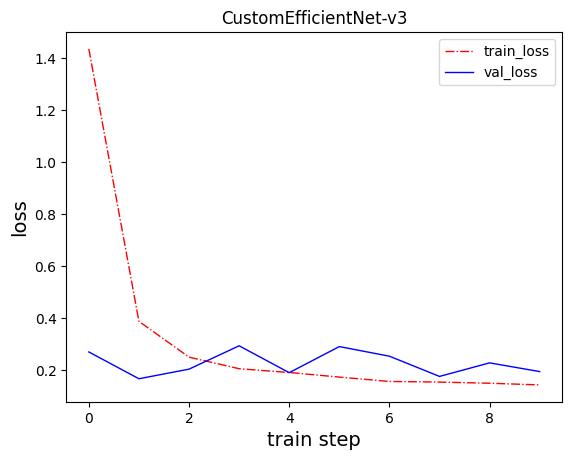

CustomEfficientNet-v3 Accuracies:
Training Accuracy: 97.17121371108779
Validation Accuracy: 95.09433962264151


In [ ]:
plot_loss(losses_list, val_losses_list, name)
printAccuracies(model, name)

# Best Model Evaluation

In [12]:
model, _ = buildCustomEfficientNet()
name = "CustomEfficientNet-v3"
model.load_state_dict(torch.load(results_path + f'{name}.ckpt'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [13]:
# calculate test dataset accuracy
print(f'Testing Accuracy: {test(model, test_loader)}')

Testing Accuracy: 93.20754716981132


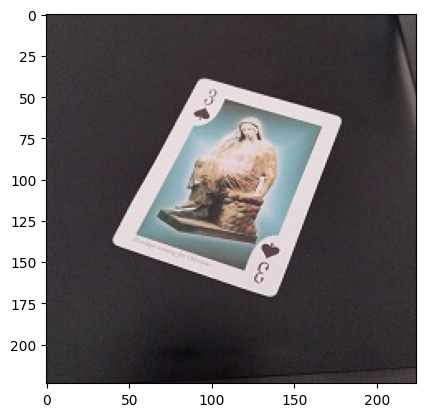

four of hearts


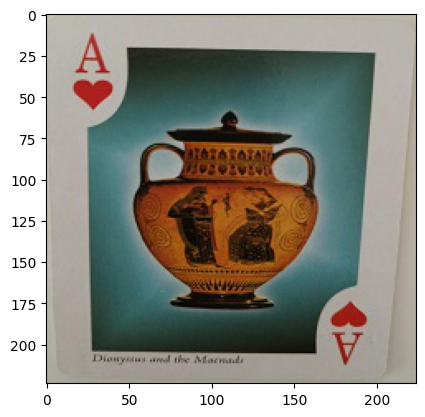

ace of hearts


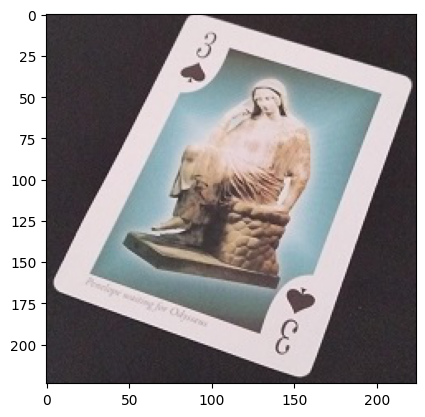

six of hearts


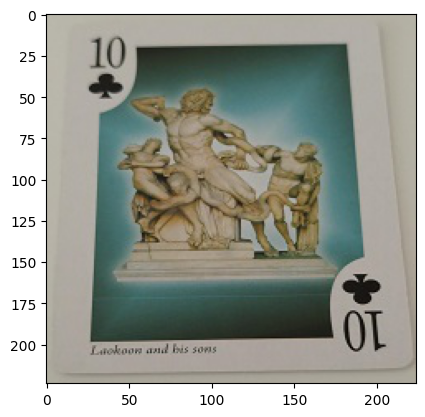

ten of clubs


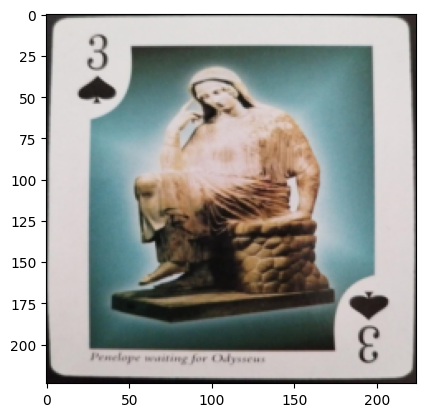

three of spades


In [18]:
# try some real images we took
model.eval()
image_path = data_path + 'real/'

real_dataset = Dataset(image_path, tr)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=256, shuffle=False)

images, labels = next(iter(real_loader))
images = images.to(device)
# print(images.shape)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

for i, image in enumerate(images):
  image = image.cpu()
  image = image.permute(1, 2, 0)
  showNormalizedImage(image)
  plt.show()
  print(number_to_labels[predicted[i].item()])
